# Imports

In [936]:
import os
import math
import numpy as np
import pandas as pd
import transformers
from datasets import load_dataset
#import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA

import torch
import torchvision
from torchinfo import summary

In [138]:
DATASET_FOLDER = 'dataset'
TRANSFORMER_IMG_SIZE = (224, 224)
device = 'cuda'

# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

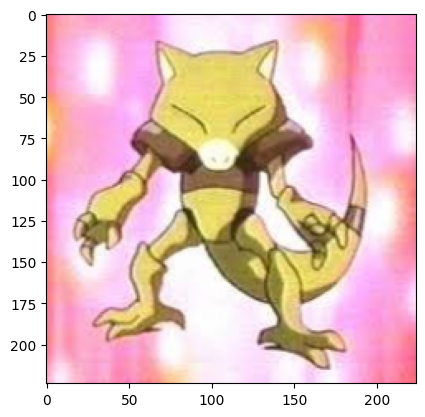

In [3]:
transforms = torchvision.transforms.Compose(
                    [torchvision.transforms.ToTensor(),
                     torchvision.transforms.Resize(TRANSFORMER_IMG_SIZE)])
dataset = torchvision.datasets.ImageFolder(DATASET_FOLDER, transform=transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)
imgs, labels = next(iter(dataloader))
plt.imshow(torch.permute(imgs[0], [1, 2, 0]))

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [4]:
backbone = transformers.AutoModel.from_pretrained('google/vit-base-patch16-224-in21k')

Load tokenizer to be used with the model

In [5]:
processor = transformers.AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9990398..1.0].


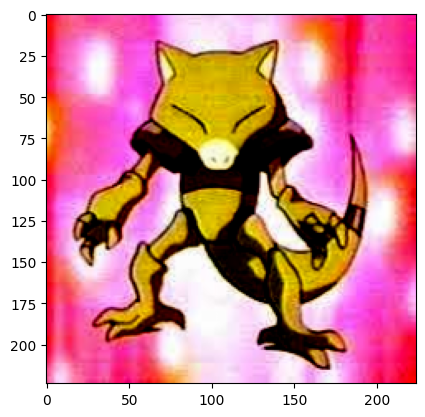

In [6]:
transforms = torchvision.transforms.Compose(
                    [torchvision.transforms.ToTensor(),
                     torchvision.transforms.Resize(TRANSFORMER_IMG_SIZE), 
                     torchvision.transforms.Normalize(mean=processor.image_mean, std=processor.image_std)])
dataset = torchvision.datasets.ImageFolder(DATASET_FOLDER, transform=transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512)
imgs, labels = next(iter(dataloader))
plt.imshow(torch.permute(imgs[0], [1, 2, 0]))

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

In [7]:
vectors = []
labels_list = []
for i, batch in enumerate(dataloader):
    imgs, labels = batch
    with torch.no_grad():
        outs = backbone(imgs)
    vectors.extend(outs.pooler_output.tolist())
    labels_list.extend(labels.tolist())
    print(f'{(i+1) / len(dataloader) * 100} %')

4.761904761904762 %
9.523809523809524 %


/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


14.285714285714285 %
19.047619047619047 %
23.809523809523807 %
28.57142857142857 %
33.33333333333333 %
38.095238095238095 %
42.857142857142854 %
47.61904761904761 %
52.38095238095239 %
57.14285714285714 %
61.904761904761905 %
66.66666666666666 %
71.42857142857143 %
76.19047619047619 %
80.95238095238095 %
85.71428571428571 %
90.47619047619048 %
95.23809523809523 %
100.0 %


In [13]:
with open('X_vect.pkl', 'wb') as f:
    pickle.dump(vectors, f)
with open('y.pkl', 'wb') as f:
    pickle.dump(labels_list, f)

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [865]:
with open(r"X_vect.pkl", "rb") as input_file:
    vectors = pickle.load(input_file)
with open(r"y.pkl", "rb") as input_file:
    labels_list = pickle.load(input_file)

In [899]:
vectors = np.array(vectors)
labels_list = np.array(labels_list)
X_train, X_test, y_train, y_test = train_test_split(vectors, labels_list, train_size=0.7, shuffle=True, stratify=labels_list)

In [900]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X).to(device, dtype=torch.float32)
        self.y = torch.LongTensor(y).to(device)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.X)

In [901]:
train_data = Dataset(X_train, y_train)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

test_data = Dataset(X_test, y_test)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

In [902]:
x, y = next(iter(train_data_loader))

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [903]:
# train_X = tf.data.Dataset.from_tensor_slices(X_train)
# train_y = tf.data.Dataset.from_tensor_slices(y_train)
# train_dataset = tf.data.Dataset.zip((train_X, train_y)).batch(128)

# test_X = tf.data.Dataset.from_tensor_slices(X_test)
# test_y = tf.data.Dataset.from_tensor_slices(y_test)
# test_dataset = tf.data.Dataset.zip((test_X, test_y)).batch(128)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layers with weights.

In [935]:
class Model(torch.nn.Module):
    def __init__(self, n_classes, backbone):
        super(Model, self).__init__()
        self.backbone = backbone
        self.L1 = torch.nn.Linear(768, 256)
        self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.LazyLinear(n_classes)

    def forward(self, x, inp_img):
        if inp_img is not None:
            x = self.backbone(inp_img)
        x = self.L1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        out = self.classifier(x)
        return out

In [905]:
model = Model(len(np.unique(labels_list)), backbone).to(device)

In [906]:
summary(model)

Layer (type:depth-idx)                                       Param #
Model                                                        --
├─ViTModel: 1-1                                              --
│    └─ViTEmbeddings: 2-1                                    152,064
│    │    └─ViTPatchEmbeddings: 3-1                          590,592
│    │    └─Dropout: 3-2                                     --
│    └─ViTEncoder: 2-2                                       --
│    │    └─ModuleList: 3-3                                  85,054,464
│    └─LayerNorm: 2-3                                        1,536
│    └─ViTPooler: 2-4                                        --
│    │    └─Linear: 3-4                                      590,592
│    │    └─Tanh: 3-5                                        --
├─Linear: 1-2                                                196,864
├─Dropout: 1-3                                               --
├─LazyLinear: 1-4                                            --
Tota

Compile the model. Choose loss and metrics.

In [907]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train the model

In [908]:
def metric(y, y_logits):
    return ((y == y_logits.argmax(dim=-1)).sum() / len(y)).tolist()

In [909]:
def train_epoch(model, optimizer, criterion, data):
    model.train()
    total_loss = 0
    total_metric = 0

    for x, y in data:
        optimizer.zero_grad()
        y_pred = model(x, None)
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_metric += metric(y, y_pred)

    return total_loss / len(data), total_metric / len(data)

In [910]:
def evaluate(model, criterion, data):
    model.eval()
    total_loss = 0
    total_metric = 0
    with torch.no_grad():
        for x, y in data:
            y_pred = model(x, None)
            loss = criterion(y_pred, y)
            total_loss += loss.item()
            total_metric += metric(y, y_pred)

    return total_loss / len(data), total_metric / len(data)

In [911]:
def train(model, optimizer, criterion, train_data, test_data, epochs, print_every=1):
    train_plot = []
    eval_plot = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(epochs):
        train_loss, train_metric = train_epoch(model, optimizer, criterion, train_data)
        eval_loss, eval_metric = evaluate(model, criterion, test_data)
        scheduler.step(eval_loss)
        train_plot.append(train_loss)
        eval_plot.append(eval_loss)
        if (epoch+1) % print_every == 0:
            print(f'EPOCH: {epoch+1}')
            print(f'TRAIN: {train_loss :.2f} loss | {train_metric * 100 :.2f}% metric')
            print(f'EVAL: {eval_loss :.2f} loss | {eval_metric * 100 :.2f}% metric')
            print(f'LR: {scheduler.get_last_lr()}')
            print('='*40)
            
    plt.plot(range(epochs), train_plot, label='train')
    plt.plot(range(epochs), eval_plot, label='val')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

EPOCH: 5
TRAIN: 2.21 loss | 48.54% metric
EVAL: 2.03 loss | 54.47% metric
LR: [0.001]
EPOCH: 10
TRAIN: 1.37 loss | 66.27% metric
EVAL: 1.49 loss | 64.57% metric
LR: [0.001]
EPOCH: 15
TRAIN: 1.01 loss | 74.15% metric
EVAL: 1.30 loss | 67.73% metric
LR: [0.001]
EPOCH: 20
TRAIN: 0.77 loss | 80.21% metric
EVAL: 1.22 loss | 69.48% metric
LR: [0.001]
EPOCH: 25
TRAIN: 0.60 loss | 84.37% metric
EVAL: 1.17 loss | 70.17% metric
LR: [0.001]
EPOCH: 30
TRAIN: 0.50 loss | 87.06% metric
EVAL: 1.16 loss | 70.49% metric
LR: [0.001]
EPOCH: 35
TRAIN: 0.41 loss | 89.62% metric
EVAL: 1.16 loss | 70.48% metric
LR: [0.001]
EPOCH: 40
TRAIN: 0.35 loss | 90.97% metric
EVAL: 1.16 loss | 70.01% metric
LR: [0.001]
EPOCH: 45
TRAIN: 0.30 loss | 91.98% metric
EVAL: 1.18 loss | 70.73% metric
LR: [0.001]
EPOCH: 50
TRAIN: 0.24 loss | 93.67% metric
EVAL: 1.17 loss | 71.07% metric
LR: [0.0001]


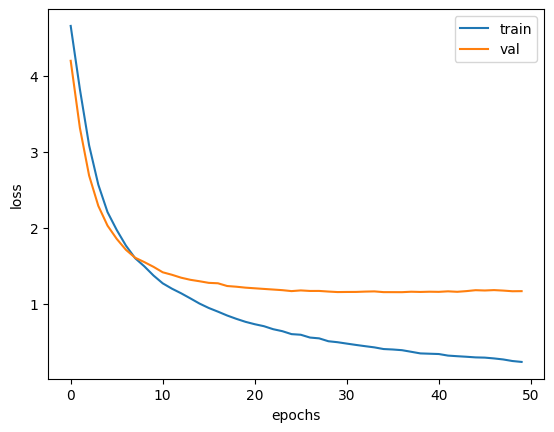

In [912]:
train(model, optimizer, criterion, train_data_loader, test_data_loader, 50, print_every=5)

In [951]:
torch.save(model.state_dict(), os.path.join('models', 'model.pth')

PicklingError: Can't pickle <class '__main__.Model'>: it's not the same object as __main__.Model

# Evaluation

Evalute the model on test data.

In [913]:
eval_loss, eval_metric = evaluate(model, criterion, test_data_loader)
print(f'EVAL: {eval_loss :.2f} loss | {eval_metric * 100 :.2f}% metric')

EVAL: 1.17 loss | 71.07% metric


Plot confusion matrix.

[Text(0, 0, 'Abra'),
 Text(0, 1, 'Aerodactyl'),
 Text(0, 2, 'Alakazam'),
 Text(0, 3, 'Arbok'),
 Text(0, 4, 'Arcanine'),
 Text(0, 5, 'Articuno'),
 Text(0, 6, 'Beedrill'),
 Text(0, 7, 'Bellsprout'),
 Text(0, 8, 'Blastoise'),
 Text(0, 9, 'Bulbasaur'),
 Text(0, 10, 'Butterfree'),
 Text(0, 11, 'Caterpie'),
 Text(0, 12, 'Chansey'),
 Text(0, 13, 'Charizard'),
 Text(0, 14, 'Charmander'),
 Text(0, 15, 'Charmeleon'),
 Text(0, 16, 'Clefable'),
 Text(0, 17, 'Clefairy'),
 Text(0, 18, 'Cloyster'),
 Text(0, 19, 'Cubone'),
 Text(0, 20, 'Dewgong'),
 Text(0, 21, 'Diglett'),
 Text(0, 22, 'Ditto'),
 Text(0, 23, 'Dodrio'),
 Text(0, 24, 'Doduo'),
 Text(0, 25, 'Dragonair'),
 Text(0, 26, 'Dragonite'),
 Text(0, 27, 'Dratini'),
 Text(0, 28, 'Drowzee'),
 Text(0, 29, 'Dugtrio'),
 Text(0, 30, 'Eevee'),
 Text(0, 31, 'Ekans'),
 Text(0, 32, 'Electabuzz'),
 Text(0, 33, 'Electrode'),
 Text(0, 34, 'Exeggcute'),
 Text(0, 35, 'Exeggutor'),
 Text(0, 36, 'Farfetchd'),
 Text(0, 37, 'Fearow'),
 Text(0, 38, 'Flareon'),
 Text(0

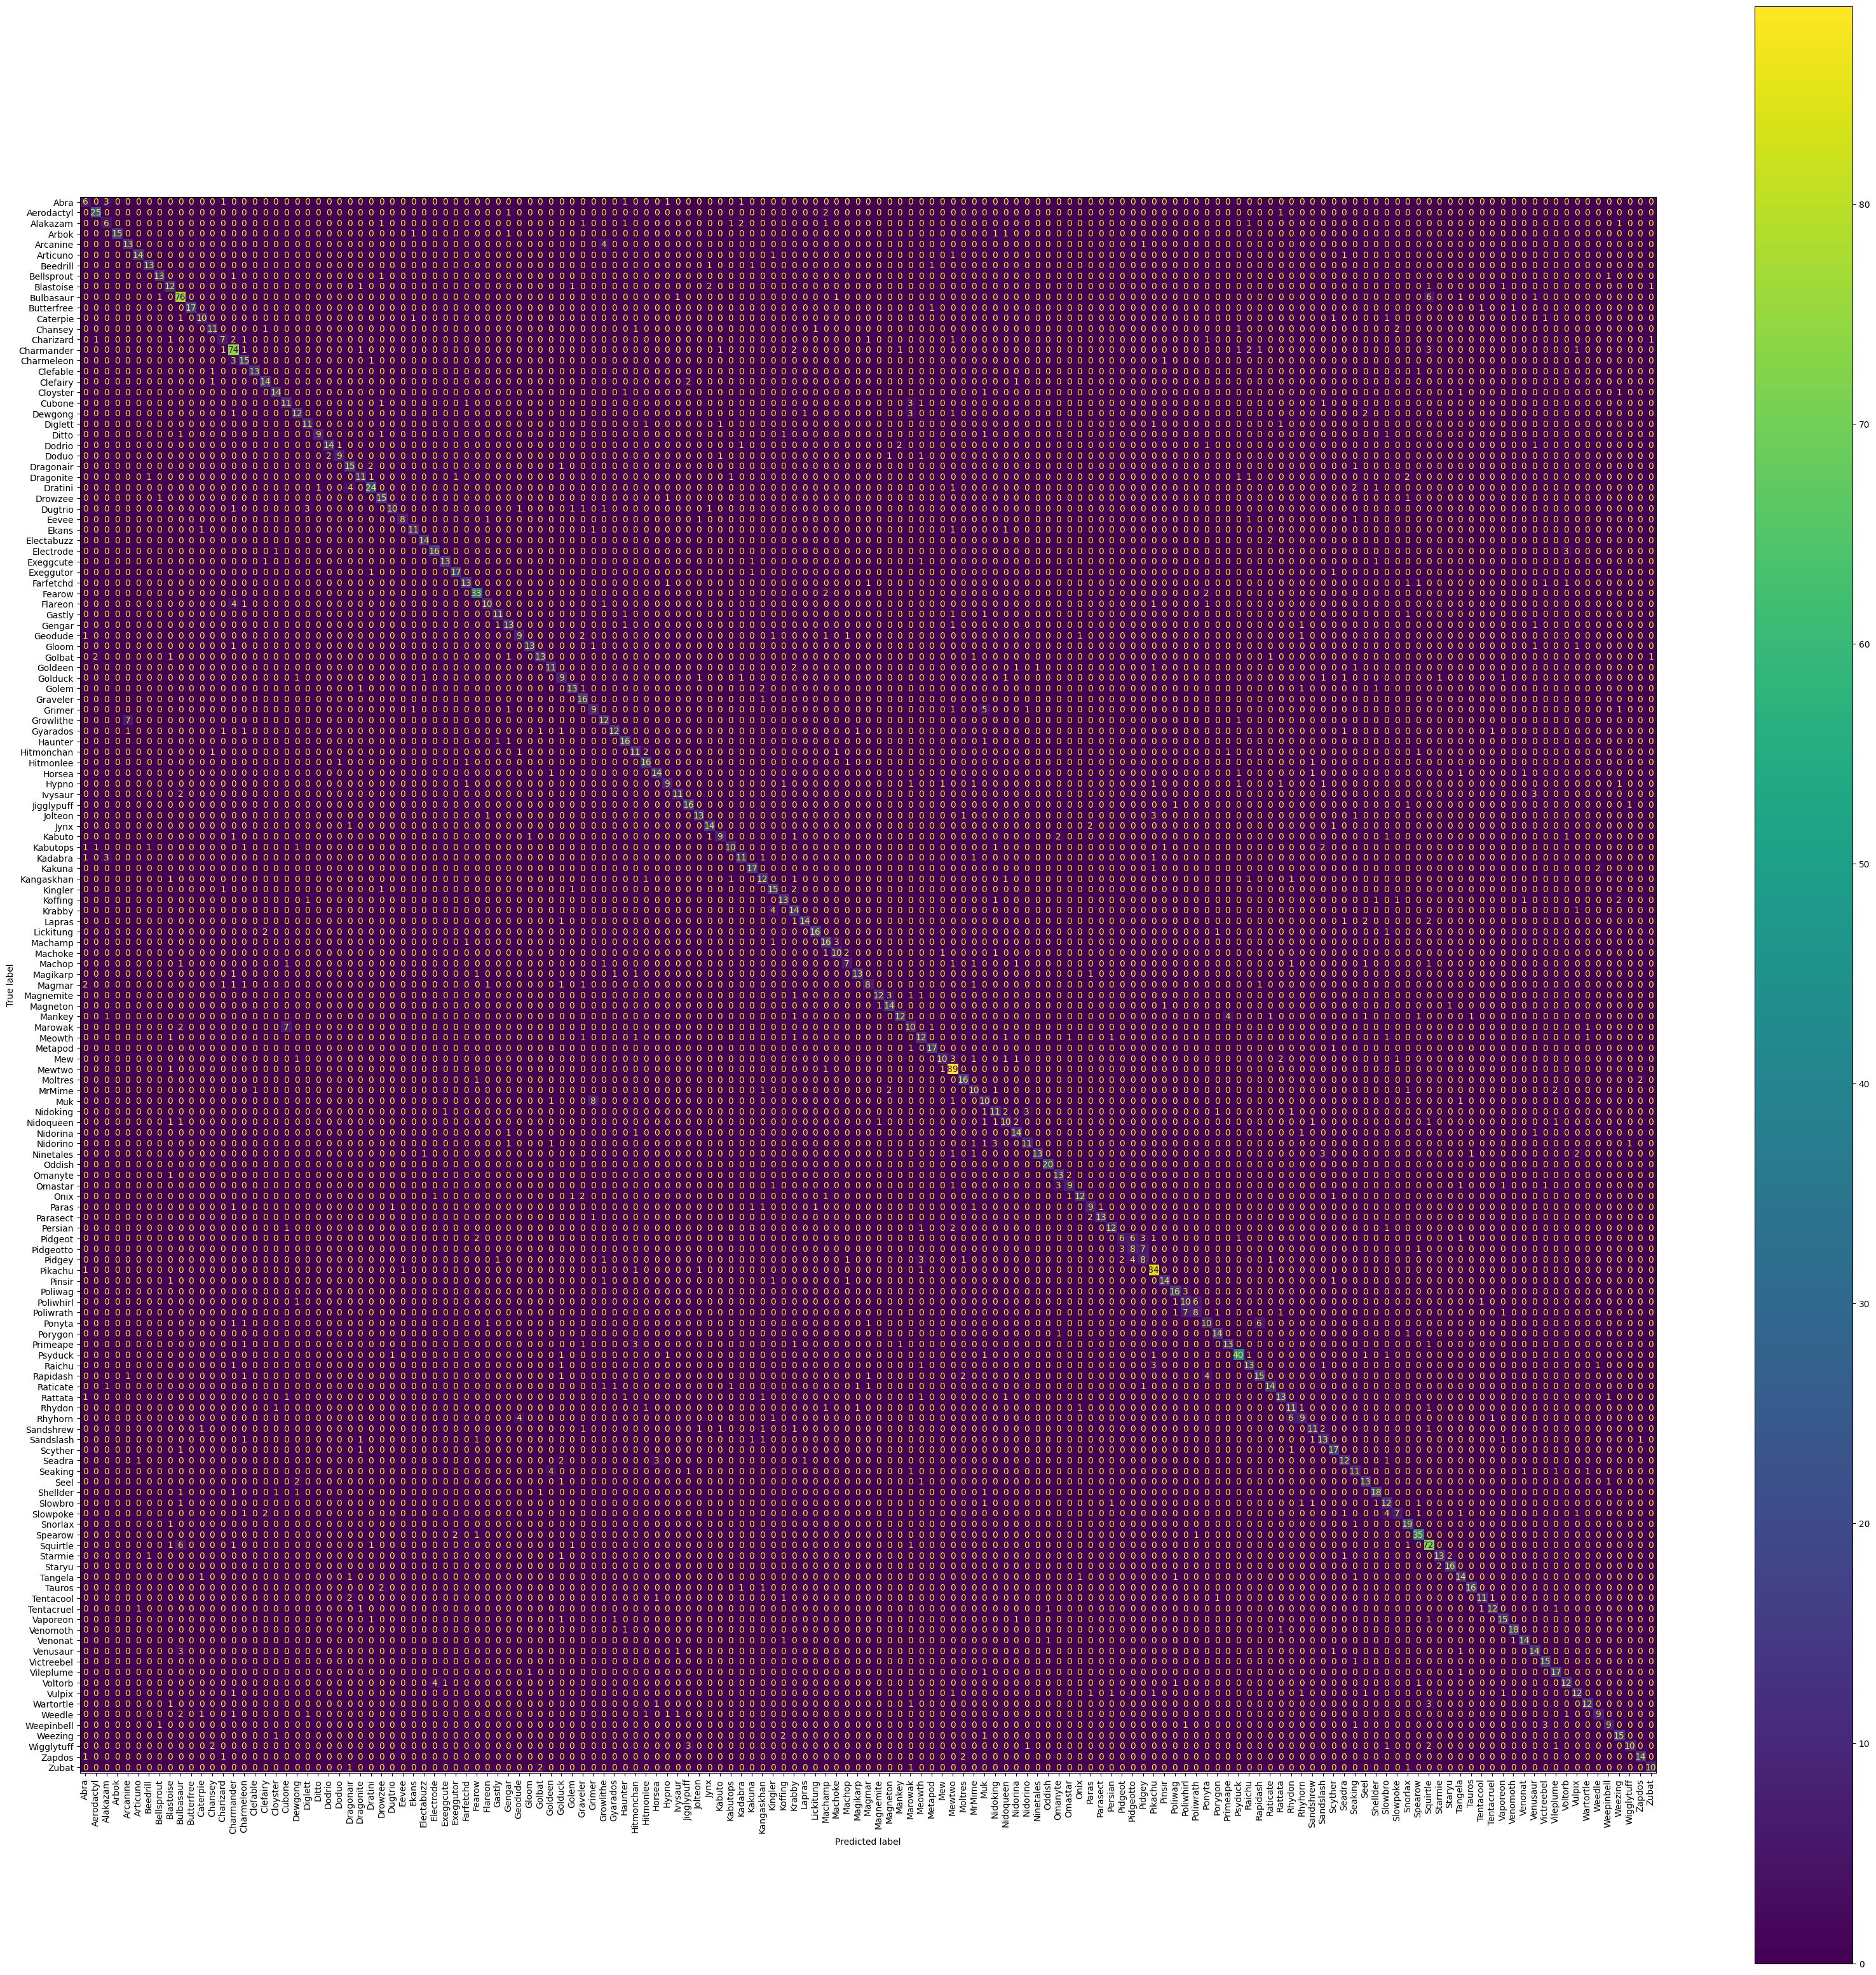

In [934]:
y_preds = model(torch.Tensor(X_test).to(device), None).argmax(dim=-1)
fig, ax = plt.subplots(figsize=(40, 40))
ConfusionMatrixDisplay.from_predictions(y_test, y_preds.cpu(), ax=ax)
ax.xaxis.set_ticklabels(dataset.class_to_idx.keys())
ax.tick_params(axis='x', labelrotation=90)
ax.yaxis.set_ticklabels(dataset.class_to_idx.keys())

Perform dimensiality reduction and plot the extracted features. Do classes form clusters?

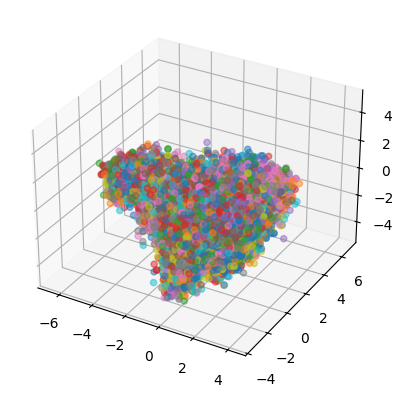

In [950]:
def get_features_labels(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for x, y in dataloader:
            x = model.L1(x)
            features.append(x.cpu().numpy())
            labels.extend(y.cpu().numpy())
    return np.vstack(features), np.hstack(labels)

features, labels = get_features_labels(model, train_data_loader)
reduced_dimensiality = PCA(n_components=3).fit_transform(vectors)
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(reduced_dimensiality[:, 0], reduced_dimensiality[:, 1], reduced_dimensiality[:, 2], c=labels_list, cmap='tab10', alpha=0.5)

# Bonus

Check if the feature extractor model can be used without a classifier layer (how large is the average feature vector similarity inbetween same in different classes)